In [1]:
import sys
from pathlib import Path
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

sys.path.append('..')
from libs.constants import *
%matplotlib notebook

In [2]:
def polyfit(x, y):
    coef = np.polyfit(x[:-1], y[:-1], 10)
    f = np.poly1d(coef)
    return f(x)

def moving_average(signal, period):
    buffer = [np.nan] * period
    for i in range(period,len(signal)):
        buffer.append(signal[i-period:i].mean())
    return buffer
    
def get_xyz_from_exl(file_path):
    df = pd.read_excel(file_path, sheet_name='3D')
    d = {
        'x': polyfit(df['time'], df['bat(X)']),
        'y': polyfit(df['time'], df['bat(Y)']),
        'z': polyfit(df['time'], df['bat(Z)']),
        't': df['time']
    }
    xyzt = pd.DataFrame(data=d)
    return xyzt

In [3]:
xls_sheets_path = processed_path / '190526'

no1_xyzt = get_xyz_from_exl(str(xls_sheets_path / 'no1_bat298.xls'))
no2_xyzt = get_xyz_from_exl(str(xls_sheets_path / 'no2_bat298.xls'))
no3_xyzt = get_xyz_from_exl(str(xls_sheets_path / 'no3_bat298.xls'))
no5_xyzt = get_xyz_from_exl(str(xls_sheets_path / 'no5_bat298.xls'))
no1_xyzt.head()

/home/lee/.pyenv/versions/3.7.0/envs/jupyter_bat/lib/python3.7/site-packages/ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  
/home/lee/.pyenv/versions/3.7.0/envs/jupyter_bat/lib/python3.7/site-packages/ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  
/home/lee/.pyenv/versions/3.7.0/envs/jupyter_bat/lib/python3.7/site-packages/ipykernel_launcher.py:2: RankWarning: Polyfit may be poorly conditioned
  


,x,y,z,t
0,1318.818604,1738.643715,-1805.056458,-4.666667
1,1320.757324,1670.351494,-1738.340088,-4.633333
2,1286.630981,1608.624519,-1761.184631,-4.600000
3,1260.631042,1544.110771,-1771.399902,-4.566667
4,1250.060181,1474.178185,-1739.591003,-4.533333


In [31]:
def line_3d_plot(df):
    %matplotlib notebook
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(111, projection='3d')

    # plot bat's line
    xs = 4.5 - (df['x'] + 1000) / 1000
    ys = df['y'] / 1000
    zs = 9 - (3000 - df['z']) / 1000
    ax.scatter(zs, xs, ys, s=10, alpha=0.7)
    ax.scatter(zs[0], xs[0], ys[0], s=10, edgecolor='w', color='orange')
    
    # plot obstacle
    ob_x = np.linspace(2.125 - 0.5, 2.125 + 0.5, 100)
    ob_y = np.linspace(0, 2, 100)
    ob_x, ob_y = np.meshgrid(ob_x, ob_y)
    ob_z = 6.5
    ax.plot_surface(ob_z, ob_x, ob_y, alpha=0.8, color='b')
    
    # settings
    plt.xlim(3.5, 9)
    plt.ylim(0, 4.5)
    ax.set_xlabel('z')
    ax.set_ylabel('x')
    ax.set_zlabel('y')
    
    plt.show()
    
    return fig, ax

    
def get_derivative(xs, zs, dt):
    '''
    get speed or acceleration array.
    
    parameters
    ----------
    df: pandas DataFrame
    xs:
    
    retruns
    -------
    '''
    dx = (xs[1:] - xs[:-1]) / dt
    dz = (zs[1:] - zs[:-1]) / dt
    ds = np.sqrt(dx**2 + dz**2)
    return ds, dx, dz

    
def line_2d_plot(df, s_or_a=None): 
    '''
    plot line 2D
    
    parameters
    ----------
    df: pandas DataFrame
    s_or_a: None, 'speed' or 'acceleration'
    '''
    xs = 4.5 - (df['x'] + 1000) / 1000
    zs = 9 - (3000 - df['z']) / 1000
    xs = np.array(xs[:-1])
    zs = np.array(zs[:-1])
    
    fig = plt.figure(figsize=(10, 10), facecolor='white')
    plt.plot(zs[0], xs[0], 'o' , color='orange')
    
    if s_or_a in ['speed', 'acceleration']:
        ds, dx, dz = get_derivative(xs, zs, df['t'][1]-df['t'][0])
        if s_or_a == 'acceleration':
            ds, _, _ = get_derivative(dx, dz, df['t'][1]-df['t'][0])
            
        mymap = LinearSegmentedColormap.from_list('rainbow',['blue','red'])
        
        levels = np.linspace(ds.min(), ds.max(), num=100)
        CS3 = plt.contourf([[0, 0], [0, 0]], levels, cmap='rainbow')
        plt.clf()
        
        for x1, x2, y1, y2, d in zip(zs[:-1], zs[1:], xs[:-1], xs[1:], ds):
            # setting rgb color based on z normalized to my range
            r = (d - ds.min()) / (ds.max() - ds.min())
            plt.plot([x1, x2], [y1, y2], color=cm.hsv(r))
        plt.colorbar(CS3) # using the colorbar info I got from contourf
    else:
        plt.plot(zs, xs)
        
    # plot obstacle
    ob_x = np.linspace(2.125 - 0.5, 2.125 + 0.5, 100)
    ob_z = 6.5 * np.ones(100)
    plt.plot(ob_z, ob_x, color='black')

    plt.xlim(3.5, 9)
    plt.ylim(0, 4.5)
    plt.xlabel('z')
    plt.ylabel('x')
   
    plt.show()

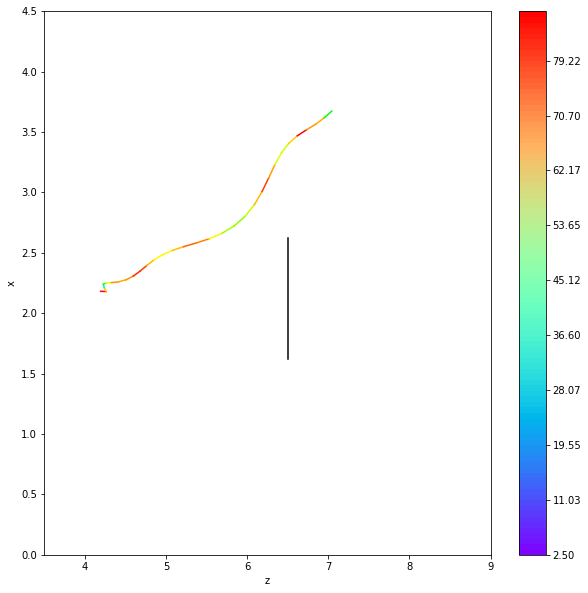

In [32]:
%matplotlib notebook
%matplotlib inline
line_2d_plot(no1_xyzt, s_or_a='acceleration')

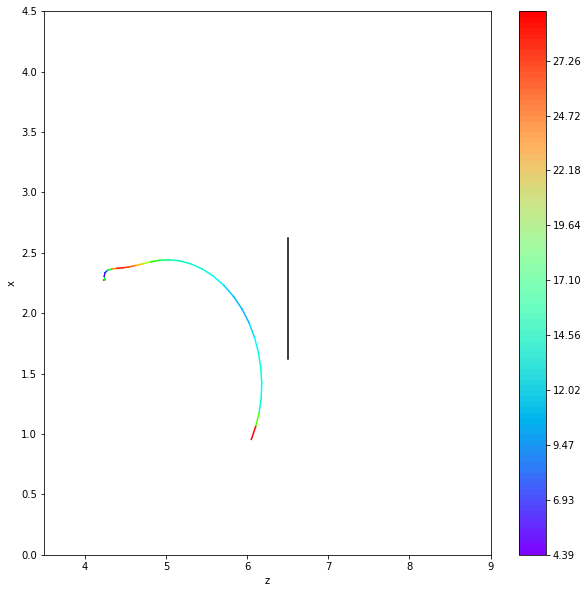

In [33]:
line_2d_plot(no2_xyzt, s_or_a='acceleration')

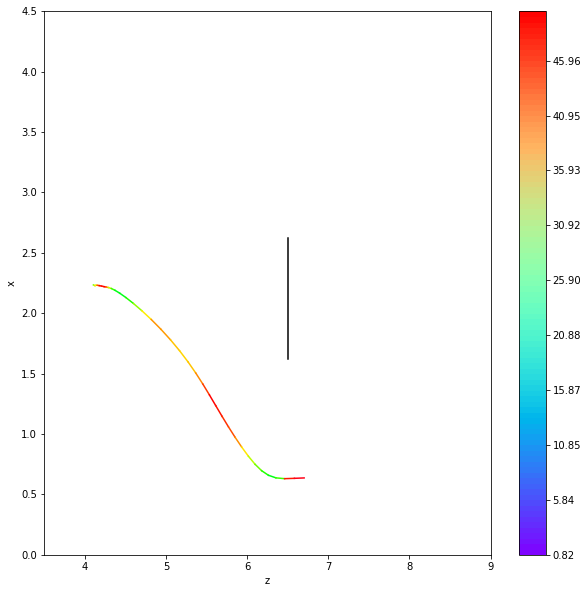

In [35]:
line_2d_plot(no3_xyzt, s_or_a='acceleration')

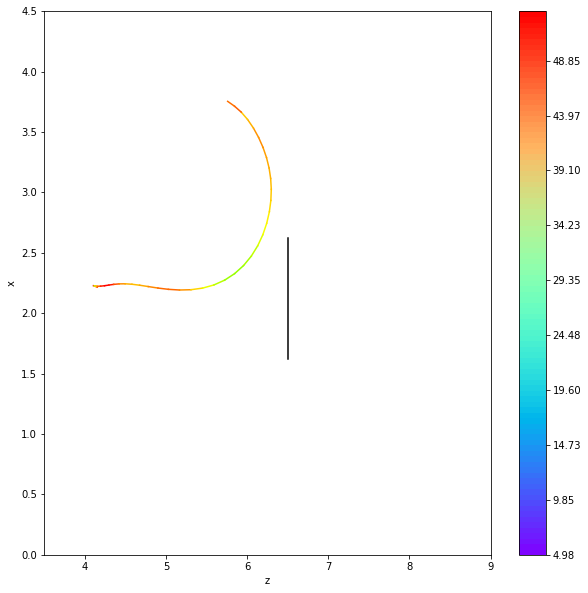

In [37]:
line_2d_plot(no5_xyzt, s_or_a='acceleration')

<IPython.core.display.Javascript object>


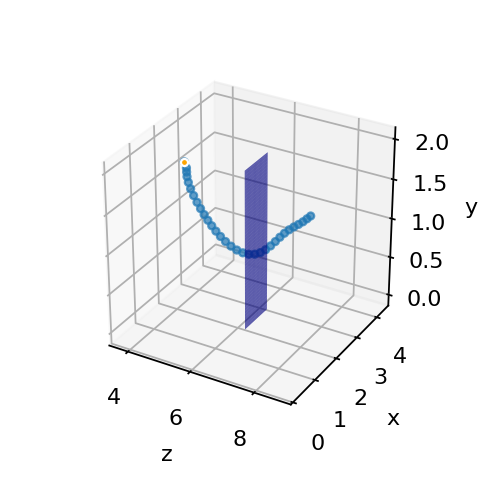

(<Figure size 300x300 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x11338b048>)

In [10]:
line_3d_plot(no1_xyzt)

<IPython.core.display.Javascript object>


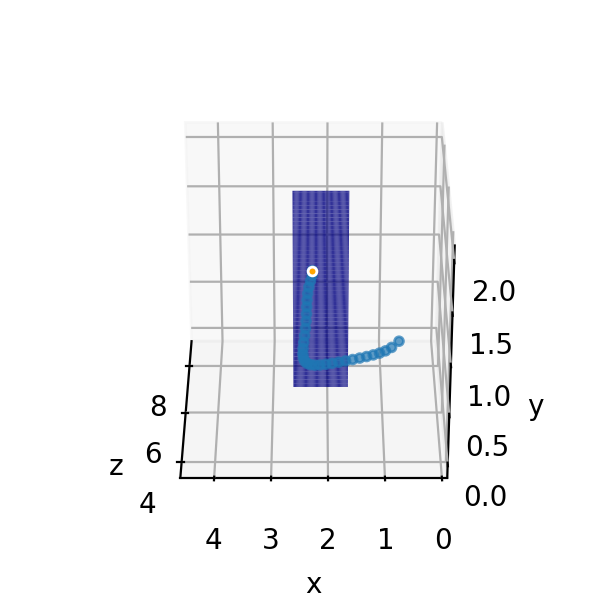

In [7]:
fig, ax = line_3d_plot(no2_xyzt)

def init():
    return fig,
    
def animate(i):
    ax.view_init(elev=30., azim=3.6*i)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, blit=True)
# HTML(ani.to_html5_video())

In [8]:
ani.save('batline2.mp4', writer='imagemagick', fps=15)